In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast

## Load Covid19india Data

In [29]:
dataframes = get_covid19india_api_data()

In [30]:
predictions_dict = {}

## Select Districts to fit on

In [6]:
districts_to_show = [('Maharashtra', 'Pune'), 
                     ('Maharashtra', 'Mumbai'), 
                     ('Rajasthan', 'Jaipur'), 
                     ('Gujarat', 'Ahmedabad'), 
                     ('Karnataka', 'Bengaluru Urban'),
                     ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

fitting to data with "train_on_val" set to False ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
21  Maharashtra   Mumbai 2020-05-17       15657.0         19809.2     719.8   
22  Maharashtra   Mumbai 2020-05-18       16627.6         21098.6     757.0   
23  Maharashtra   Mumbai 2020-05-19       17691.0         22487.6     794.2   
24  Maharashtra   Mumbai 2020-05-20       18622.0         23907.8     829.2   
25  Maharashtra   Mumbai 2020-05-21       19606.8         25404.2     867.6   

    recovered  
21     3432.4  
22     3714.0  
23     4002.4  
24     4456.6  
25     4929.8  
val
          state district       date  hospitalised  total_infected  deceased  \
0  Maharashtra   Mumbai 2020-05-22       20731.4         27245.6     913.8   
1  Maharashtra   Mumbai 2020-05-23       21719.0         28816.4     950.8   
2  Maharashtra   Mumbai 2020-05-24       22515.0         30311.2     987.4   
3  Maharashtra   Mumbai 2020-05-25       23382.0         31664.6    1

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
28  Maharashtra   Mumbai 2020-05-24       22515.0         30311.2     987.4   
29  Maharashtra   Mumbai 2020-05-25       23382.0         31664.6    1025.0   
30  Maharashtra   Mumbai 2020-05-26       24167.6         32998.2    1062.2   
31  Maharashtra   Mumbai 2020-05-27       24908.0         34018.0    1097.0   
32  Maharashtra   Mumbai 2020-05-28       25700.0         35485.0    1135.0   

    recovered  
28     6808.8  
29     7257.6  
30     7768.4  
31     8013.0  
32     8650.0  
val
 None
100%|██████████| 700/700 [00:28<00:00, 24.74trial/s, best loss: 3.6298862979636635]
best parameters
 {'E_hosp_ratio': 0.03540706309478475, 'I_hosp_ratio': 0.36888884665645744, 'P_fatal': 0.04474559302061647, 'P_severe': 0.8248934536381691, 'T_inc': 4.9518695992651605, 'T_inf': 3.2738965048825577, 'T_recov_severe': 43.46061106028372, 'lockdown_R0': 1.302235519372927}


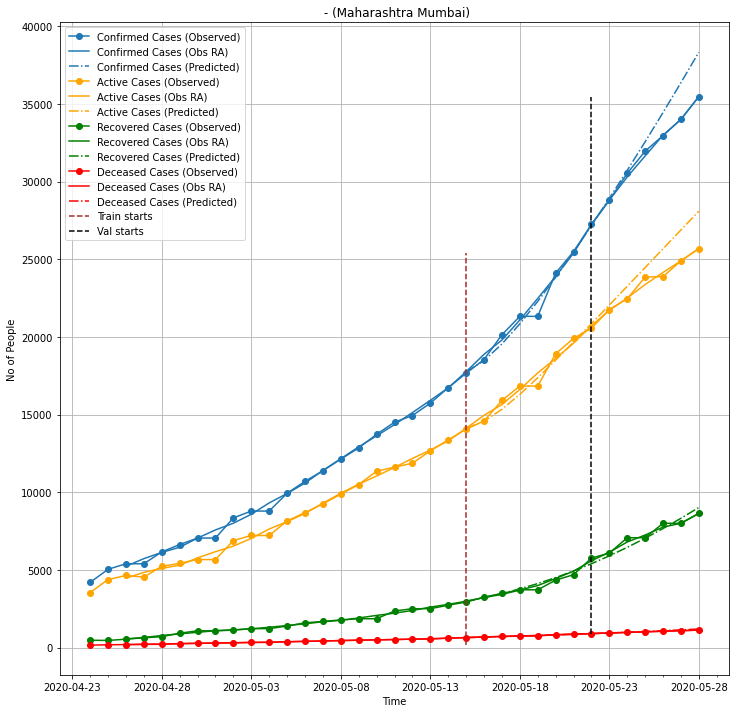

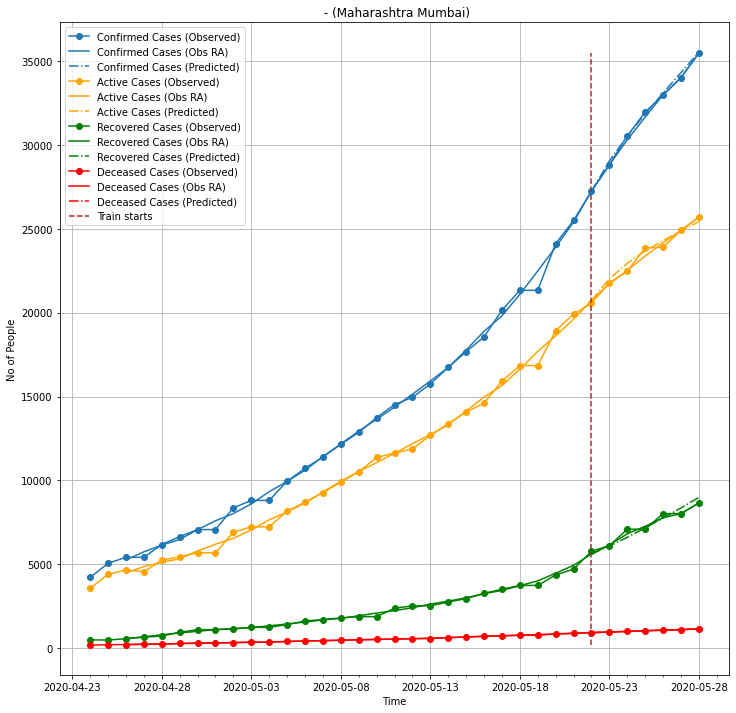

In [8]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=True, initialisation='intermediate', num_evals=700,
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, num_evals=700,
                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
    predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

## Create Master Loss Dataframe

### M1 Loss

In [11]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai         1.25           1.44     2.19      3.34   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai         7.25           7.82     4.54     12.46

### M2 Loss

In [12]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         1.17           0.67     0.83      3.38

## Plot Forecasts

getting forecasts ..


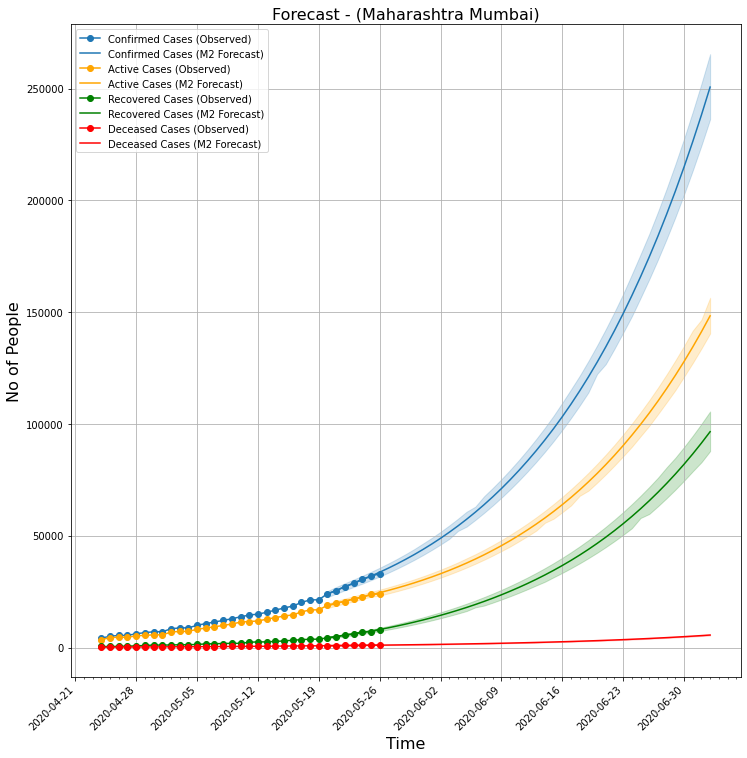

In [13]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Load Mumbai CSV

In [9]:
df_mumbai = pd.read_csv('../../outputs/mumbai-20200516-123414.csv')
df_mumbai['predictionDate'] = pd.to_datetime(df_mumbai['predictionDate'])

In [10]:
df_mumbais = []

In [11]:
split_indices = [None] + list(df_mumbai[df_mumbai['predictionDate'] == '2020-06-22'].index) + [None]
for i in range(len(split_indices) - 1):
    if split_indices[i] != None and split_indices[i+1] != None:
        df_mumbais.append(df_mumbai.loc[split_indices[i]+1:split_indices[i+1], :].reset_index(drop=True))
    else:
        df_mumbais.append(df_mumbai.loc[split_indices[i]:split_indices[i+1], :].reset_index(drop=True))

In [12]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']

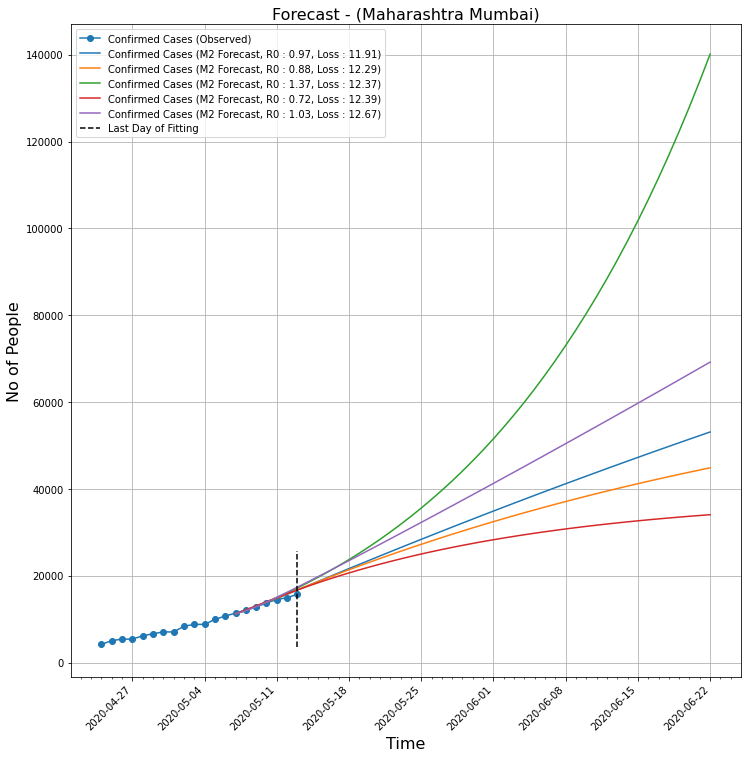

In [26]:
R0s_array = [0.97, 0.88, 1.37, 0.72, 1.03]
loss_array = [11.91, 12.29, 12.37, 12.39, 12.67]
which_compartments = ['total_infected']
fig, ax = plt.subplots(figsize=(12, 12))

if 'total_infected' in which_compartments:
    ax.plot(df_true.loc[df_true['date'] <= '2020-05-13', 'date'], df_true.loc[df_true['date'] <= '2020-05-13', 'total_infected'],
            '-o', color='C0', label='Confirmed Cases (Observed)')
if 'hospitalised' in which_compartments:
    ax.plot(df_true['date'], df_true['hospitalised'],
            '-o', color='orange', label='Active Cases (Observed)')

for i, df in enumerate(df_mumbais[0:5]):
    df = df[np.logical_not(df['total_mean'].isna())]
    if 'total_infected' in which_compartments:
        ax.plot(df['predictionDate'], df['total_mean'],
                '-', label='Confirmed Cases (M2 Forecast, R0 : {}, Loss : {})'.format(R0s_array[i], loss_array[i]))
    if 'hospitalised' in which_compartments:
        sns.lineplot(x="predictionDate", y="hospitalized_mean", data=df,
                     ls='-', label='Active Cases (M2 Forecast, R0 : {}, Loss : {}))'.format(R0s_array[i], loss_array[i]))
    if 'recovered' in which_compartments:
        ax.plot(df_true['date'], df_true['recovered'],
                '-o', color='green', label='Recovered Cases (Observed)')
        sns.lineplot(x="predictionDate", y="recovered_mean", data=df,
                     ls='-', color='green', label='Recovered Cases (M2 Forecast, R0 : {}, Loss : {}))'.format(R0s_array[i], loss_array[i]))
    if 'deceased' in which_compartments:
        ax.plot(df_true['date'], df_true['deceased'],
                '-o', color='red', label='Deceased Cases (Observed)')
        sns.lineplot(x="predictionDate", y="deceased_mean", data=df,
                     ls='-', color='red', label='Deceased Cases (M2 Forecast, R0 : {}, Loss : {}))'.format(R0s_array[i], loss_array[i]))
ax.plot([datetime.datetime.strptime('2020-05-13', '%Y-%m-%d'), datetime.datetime.strptime('2020-05-13', '%Y-%m-%d')],
        [min(df_true['hospitalised']), max(df_true['hospitalised'])], '--', color='black', label='Last Day of Fitting')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right')
plt.legend()
plt.title('Forecast - (Maharashtra Mumbai)', fontsize=16)
plt.grid()

In [15]:
for i in range(len(df_mumbais)):
    print(i, df_mumbais[i].loc[df_mumbais[i]['predictionDate'] == '2020-05-31', 'total_mean'])

0 50    33983.0
Name: total_mean, dtype: float64
1 50    31753.0
Name: total_mean, dtype: float64
2 50    48966.0
Name: total_mean, dtype: float64
3 50    27883.0
Name: total_mean, dtype: float64
4 50    39980.0
Name: total_mean, dtype: float64


In [14]:
indexes = [1, 5, 6, 7, 9, 10]
for index in sorted(indexes, reverse=True):
    del df_mumbais[index]

## Create and Save Output CSV

In [85]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [88]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [146]:
df_mumbai_old = get_data(dataframes, state='Maharashtra', district='Mumbai', disable_tracker=True)

In [147]:
df_mumbai_old

,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,mumbai,2020-04-11,1182,1036,71,75
1,maharashtra,mumbai,2020-04-12,1399,1211,97,91
2,maharashtra,mumbai,2020-04-13,1549,1308,141,100
3,maharashtra,mumbai,2020-04-14,1753,1478,164,111
4,maharashtra,mumbai,2020-04-15,1936,1642,181,113
5,maharashtra,mumbai,2020-04-16,2043,1725,202,116
6,maharashtra,mumbai,2020-04-17,2120,1760,239,121
7,maharashtra,mumbai,2020-04-18,2509,2103,281,125
8,maharashtra,mumbai,2020-04-19,2798,2357,310,131
9,maharashtra,mumbai,2020-04-20,3050,2518,394,138


In [32]:
16364 - 8650

7714

In [33]:
20851 - 25700

-4849

In [34]:
1227 - 1135

92

In [35]:
38442 - 35485

2957

In [36]:
2957 - 7714 - 92

-4849

In [106]:
7714/28

275.5

In [144]:
df_mumbai_new = copy.copy(df_mumbai_old)
df_mumbai_new.set_index('date', inplace=True)
big_jump = df_mumbai_new.loc['2020-05-30', 'recovered'] - df_mumbai_new.loc['2020-05-29', 'recovered']

days = 28

for i, day_number in enumerate(range(days-2, -1, -1)):
    date = datetime.datetime.strptime('2020-05-29', '%Y-%m-%d') - datetime.timedelta(days=day_number)
    offset = np.random.binomial(1, (big_jump%days)/days)
    df_mumbai_new.loc[date, 'recovered'] = df_mumbai_new.loc[date, 'recovered'] + ((i+1)*big_jump)//days + offset
    df_mumbai_new.loc[date, 'hospitalised'] = df_mumbai_new.loc[date, 'hospitalised'] - ((i+1)*big_jump)//days - offset
    
df_mumbai_new['total_infected'] = df_mumbai_new['hospitalised'] + df_mumbai_new['deceased'] + df_mumbai_new['recovered']
df_mumbai_new.columns = ['state', 'district', 'new_hospitalised', 'new_total_infected', 'new_deceased', 'new_recovered']
del df_mumbai_new['state']
del df_mumbai_new['district']

In [145]:
df_mumbai_new

,new_hospitalised,new_total_infected,new_deceased,new_recovered
date,,,,
2020-04-24,3555,4205,167,483
2020-04-25,4388,5049,191,470
2020-04-26,4652,5407,204,551
2020-04-27,4547,5407,219,641
2020-04-28,5239,6169,219,711
2020-04-29,5438,6644,270,936
2020-04-30,5679,7061,290,1092
2020-05-01,5673,7061,296,1092
2020-05-02,6903,8359,322,1134


In [97]:
df_mumbai_old.set_index('date', inplace=True)
df_mumbai_old.columns = ['state', 'district', 'old_hospitalised', 'old_total_infected', 'old_deceased', 'old_recovered']

In [98]:
df_mumbai_old

,state,district,old_hospitalised,old_total_infected,old_deceased,old_recovered
date,,,,,,
2020-04-24,Maharashtra,Mumbai,3555,4205,167,483
2020-04-25,Maharashtra,Mumbai,4388,5049,191,470
2020-04-26,Maharashtra,Mumbai,4652,5407,204,551
2020-04-27,Maharashtra,Mumbai,4547,5407,219,641
2020-04-28,Maharashtra,Mumbai,5239,6169,219,711
2020-04-29,Maharashtra,Mumbai,5438,6644,270,936
2020-04-30,Maharashtra,Mumbai,5679,7061,290,1092
2020-05-01,Maharashtra,Mumbai,5673,7061,296,1092
2020-05-02,Maharashtra,Mumbai,6903,8359,322,1134


In [100]:
df_mumbai_comb = df_mumbai_old.merge(df_mumbai_new, left_index=True, right_index=True)

In [102]:
df_mumbai_comb.loc['2020-05-14':, ['old_hospitalised', 'new_hospitalised', 'old_recovered', 'new_recovered', 'old_total_infected', 'new_total_infected']]

,old_hospitalised,new_hospitalised,old_recovered,new_recovered,old_total_infected,new_total_infected
date,,,,,,
2020-05-14,13378,13378.0,2739,2739.0,16738,16738.0
2020-05-15,14072,14072.0,2944,2944.0,17671,17671.0
2020-05-16,14599,14599.0,3260,3260.0,18555,18555.0
2020-05-17,15918,15367.0,3498,4049.0,20150,20150.0
2020-05-18,16848,15746.0,3730,4832.0,21335,21335.0
2020-05-19,16848,15195.0,3730,5383.0,21335,21335.0
2020-05-20,18925,16721.0,4352,6556.0,24118,24118.0
2020-05-21,19916,17161.0,4702,7457.0,25500,25500.0
2020-05-22,20573,17267.0,5769,9075.0,27251,27251.0
